<a href="https://colab.research.google.com/github/SnazzyBeatle115/UG54/blob/main/chapters/Finance/PortfolioMath_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolios
## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. **See risk through a portfolio lens** — Grasp Markowitz's insight that an asset's danger depends on what it adds to the *whole* mix, not on its stand-alone volatility
2. **Express returns, means, and variance with matrix algebra** — Use $R_p = W'R$, $E[R_p]=W'E[R]$, and $\text{Var}(R_p)=W'\Sigma W$ to scale from two assets to hundreds
3. **Quantify diversification benefits** — Investigate how adding a higher-volatility asset can *lower* portfolio variance when correlations are below one
4. **Compute and interpret portfolio weights** — Distinguish long-only, short, and leveraged positions; verify that weights sum to one

## 📋 Table of Contents

1. [Setup](#setup)
2. [Why Think in Portfolios?](#why-think-in-portfolios)
3. [Portfolio Weights](#portfolio-weights)
4. [Our Dataset](#our-dataset)
5. [Portfolio Returns](#portfolio-returns)
6. [Portfolio Expected Returns](#portfolio-expected-returns)
7. [Portfolio Variance](#portfolio-variance)
8. [Diversification](#diversification)
9. [The Mean-Variance Frontier](#the-mean-variance-frontier)
10. [Exercises](#exercises)
11. [Key Takeaways](#key-takeaways)

In [2]:
#@title 🛠️ Setup: Run this cell first <a id="setup"></a>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

---

## Why Think in Portfolios? <a id="why-think-in-portfolios"></a>

Harry Markowitz's great insight was to think of risk in terms of **what an asset adds to your portfolio**, not its stand-alone volatility.

> **💡 Key Insight:**
>
> Just like sugar can be good for you if you're not eating any, but terrible if you're eating a lot of it—what investors should care about is their **final diet**.
>
> If a stock brings a lot of what you already have, it will be **risky for you**.

**Why volatility alone is misleading:**

- If you have only 1% in a stock and it drops to ZERO, you lose only 1% of your portfolio
- The stock's volatility doesn't matter much at small positions
- As you buy more, it **becomes** risky **for you** because your portfolio moves more like it
- If this stock moves together with your other holdings, even a small position can feel very risky

> **📌 Remember:**
>
> The covariance across stocks is a key determinant of how much we can hold volatile stocks without adding much overall risk.

---

## Portfolio Weights <a id="portfolio-weights"></a>

The **portfolio weight** for stock $j$, denoted $w_j$, is the fraction of portfolio value held in stock $j$:

$$w_j = \frac{\text{Dollars held in stock } j}{\text{Total portfolio value}}$$

> **📌 Remember:**
>
> Portfolio weights **sum to one**:
>
> $$\sum_{j=1}^N w_j = 1 \quad \text{or in matrix notation:} \quad \mathbf{1}'W = 1$$
>
> This doesn't mean you can't borrow—just that negative weights offset positive ones.



> **📌 Warning:**
>
> We often separe the weight on the risk-free asset
>
> $$\sum_{j=1}^N w_j +w_{rf}= 1 \quad \text{risky weights can be larger than 1 if $w_{rf}$ negative} \quad \sum_{j=1}^N w_j =1-w_{rf}$$
>


| Position Type | Description | Example |
|--------------|-------------|----------|
| **Long-only** | [w_rf,w_i] ≥ 0 | $W = [0.6, 0.3],w_{rf}=0.1$  |
| **Short** | Some risky weights < 0 | $W = [1.2, -0.4],w_{rf}=0.2$ |
| **Leveraged** | sum of risky weights > 1 in absolute value | $W = [1.5, 0.5],w_{rf}=-1$ |

> We will often work with excess returns. These are portfolios that are long a risky asset and short the risk-free asset

---

## Our Dataset <a id="our-dataset"></a>

We'll work with monthly **excess returns** for:
- 🇺🇸 US equities (S&P 500, MKT)
- 🌍 International developed markets (WorldxUSA)
- 🌏 Emerging markets
- 📈 US government bonds
- 🌐 International government bonds

In [3]:
#@title 📊 Load Data

url = "https://raw.githubusercontent.com/amoreira2/UG54/main/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url)
Data['Date'] = pd.to_datetime(Data['Date'])
Data = Data.set_index('Date')



print(f"Data shape: {Data.shape}")
print(f"Date range: {Data.index[0].strftime('%Y-%m')} to {Data.index[-1].strftime('%Y-%m')}")
Data.head()

Data shape: (647, 6)
Date range: 1963-02 to 2016-12


,RF,MKT,USA30yearGovBond,EmergingMarkets,WorldxUSA,WorldxUSAGovBond
Date,,,,,,
1963-02-28,0.0023,-0.0215,-0.001878,0.098222,-0.002773,-99.000000
1963-03-31,0.0023,0.0331,0.003342,0.014149,0.000371,0.001913
1963-04-30,0.0025,0.0476,-0.001843,-0.147055,-0.003336,0.008002
1963-05-31,0.0024,0.0200,-0.001807,-0.012172,-0.000186,0.004689
1963-06-30,0.0023,-0.0177,0.001666,-0.055699,-0.011160,0.003139


In [4]:
# Convert to excess returns
Rf = Data['RF']
Data = Data.drop(columns=['RF']).subtract(Rf, axis=0)
Data = Data.dropna()
Data.head()

,MKT,USA30yearGovBond,EmergingMarkets,WorldxUSA,WorldxUSAGovBond
Date,,,,,
1963-02-28,-0.0238,-0.004178,0.095922,-0.005073,-99.002300
1963-03-31,0.0308,0.001042,0.011849,-0.001929,-0.000387
1963-04-30,0.0451,-0.004343,-0.149555,-0.005836,0.005502
1963-05-31,0.0176,-0.004207,-0.014572,-0.002586,0.002289
1963-06-30,-0.0200,-0.000634,-0.057999,-0.013460,0.000839


---

## Portfolio Returns <a id="portfolio-returns"></a>

Portfolio returns are the **dollar-weighted average** of individual position returns:


$$r_p = \sum_{j=1}^N w_j r_j = W'R$$

Where:
- $R$ is the $N \times 1$ vector of asset returns
- $W$ is the $N \times 1$ vector of weights

We can rewrite the portfolio of regular assets in terms of a portfolio of excess returns,

$$R_p=\sum_{i=2}^N w_i r_i+w_1 r_1=\sum_{i=2}^N w_i r^e_i+r_1 =W'R^e+r_f$$

where $R^e$ is the vector of risky assets excess returns and $W=[w_2,w_3,...w_N]$ is the vector of risky assets weights

- Note that even though we impose that the weights $w_i$ add up to 1, the weights W can add up to values below 1 or above 1

- Why? because we represented everything in terms of self-funded portfolios

- Here we are working directly with excess returns

In [5]:
# Construct an equal-weighted portfolio
N = len(Data.columns)
W = np.ones((N, 1)) / N

print(f"Number of assets: {N}")
print(f"Weights: {W.flatten()}")
print(f"Weights sum to: {W.sum():.4f}")

Number of assets: 5
Weights: [0.2 0.2 0.2 0.2 0.2]
Weights sum to: 1.0000


> **🐍 Python Insight: Matrix multiplication with `@`**
>
> The `@` operator performs matrix multiplication in Python:
>
> ```python
> portfolio_return = Data @ W  # T×N matrix @ N×1 vector = T×1 vector
> ```
>
> This replaces messy for loops with a single line!

In [6]:
Data=Data[Data>-1].dropna()
Data

,MKT,USA30yearGovBond,EmergingMarkets,WorldxUSA,WorldxUSAGovBond
Date,,,,,
1963-03-31,0.0308,0.001042,0.011849,-0.001929,-0.000387
1963-04-30,0.0451,-0.004343,-0.149555,-0.005836,0.005502
1963-05-31,0.0176,-0.004207,-0.014572,-0.002586,0.002289
1963-06-30,-0.0200,-0.000634,-0.057999,-0.013460,0.000839
1963-07-31,-0.0039,0.000700,0.085891,0.005200,-0.000799
...,...,...,...,...,...
2016-08-31,0.0050,-0.008617,0.024986,0.000638,-0.009752
2016-09-30,0.0025,-0.016617,0.012953,0.012536,0.009779
2016-10-31,-0.0202,-0.049660,0.002274,-0.020583,-0.043676


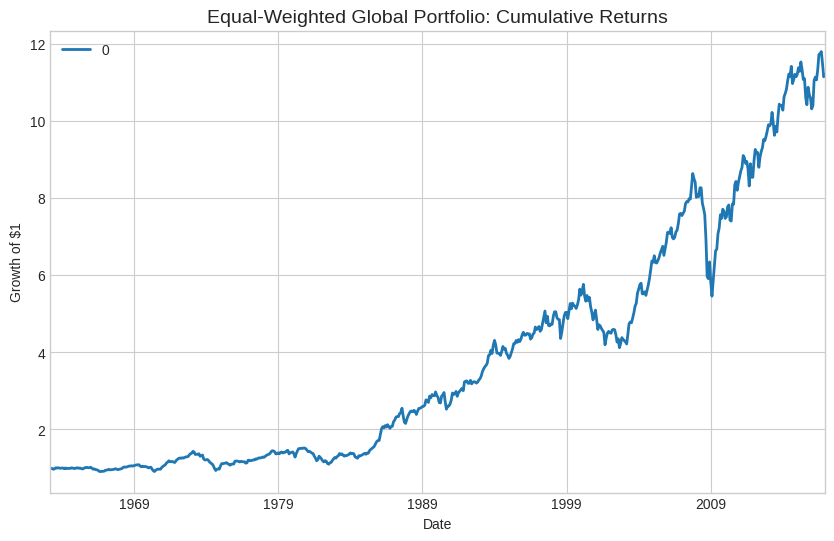

In [7]:
# Compute portfolio returns for ALL dates at once
Rp = Data @ W
# Plot cumulative returns
fig, ax = plt.subplots(figsize=(10, 6))
(1 + Rp).cumprod().plot(ax=ax, linewidth=2)
ax.set_title('Equal-Weighted Global Portfolio: Cumulative Returns', fontsize=14)
ax.set_ylabel('Growth of $1')
plt.show()

---

## Portfolio Expected Returns <a id="portfolio-expected-returns"></a>

Since expectations are **linear**, the expected portfolio return is:

$$E[r_p^e] = E\left[\sum_{j=1}^N w_j r_j^e\right] = \sum_{j=1}^N w_j E[r_j^e] = W'E[R^e]$$

If the porfolio expected excess return is $E[r_p^e]$ say 5%, what is the expected return?

In [8]:
# Estimate expected returns from historical data
E_hat = Data.mean()

print("Monthly expected excess returns:")
print(E_hat.round(4))
print("\nAnnualized expected excess returns:")
print((E_hat * 12).round(4))

Monthly expected excess returns:
MKT                 0.0052
USA30yearGovBond    0.0025
EmergingMarkets     0.0068
WorldxUSA           0.0042
WorldxUSAGovBond    0.0021
dtype: float64

Annualized expected excess returns:
MKT                 0.0622
USA30yearGovBond    0.0304
EmergingMarkets     0.0814
WorldxUSA           0.0500
WorldxUSAGovBond    0.0246
dtype: float64


In [9]:
# Two equivalent ways to compute portfolio expected return
E_rp_method1 = W.T @ E_hat  # Matrix multiplication
E_rp_method2 = Rp.mean()     # Direct average of portfolio returns

print(f"Via W'E[R]: {E_rp_method1[0]:.6f}")
print(f"Via mean(Rp): {E_rp_method2[0]:.6f}")
print(f"\nAnnualized: {E_rp_method1[0] * 12:.2%}")

Via W'E[R]: 0.004144
Via mean(Rp): 0.004144

Annualized: 4.97%


---

## Portfolio Variance <a id="portfolio-variance"></a>

Portfolio variance is **NOT** the weighted average of individual variances!

**Two-asset case:**

$$\text{Var}(r^e) = w_1^2 \text{Var}(r_1^e) + 2w_1 w_2 \text{Cov}(r_1^e, r_2^e) + w_2^2 \text{Var}(r_2^e)$$

**N-asset case:**

$$\text{Var}(r_p^e) = \sum_{j=1}^N \sum_{i=1}^N w_j w_i \text{Cov}(r_j^e, r_i^e) = W' \Sigma W$$

where $\Sigma$ is the $N \times N$ variance-covariance matrix.

> **💡 Key Insight:**
>
> For 50 assets, the formula has 50 variance terms and **2,450 covariance terms**!
> Matrix algebra saves us from nested for loops.

In [10]:
# Estimate the covariance matrix
Cov_hat = Data.cov().to_numpy()

print("Covariance matrix (monthly):")
display(Cov_hat.round(6))

Covariance matrix (monthly):


array([[ 1.950e-03,  1.110e-04,  1.298e-03,  1.265e-03,  1.870e-04],
       [ 1.110e-04,  1.229e-03, -2.040e-04, -1.300e-05,  2.640e-04],
       [ 1.298e-03, -2.040e-04,  3.550e-03,  1.664e-03,  2.490e-04],
       [ 1.265e-03, -1.300e-05,  1.664e-03,  2.185e-03,  4.220e-04],
       [ 1.870e-04,  2.640e-04,  2.490e-04,  4.220e-04,  4.070e-04]])

In [11]:
(Data@W).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 646 entries, 1963-03-31 to 2016-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       646 non-null    float64
dtypes: float64(1)
memory usage: 10.1 KB


In [12]:
# Compute portfolio variance using matrix algebra
Var_rp = (Data@W).var()[0]
Vol_rp = np.sqrt(Var_rp)
# Compute portfolio variance using matrix algebra
Var_rp_m = (W.T @ Cov_hat @ W)
Vol_rp_m = np.sqrt(Var_rp_m)

print(f"Monthly variance: {Var_rp}")
print(f"Annualized volatility: {Vol_rp * np.sqrt(12)}")


print(f"Monthly variance: {Var_rp_m}")
print(f"Annualized volatility: {Vol_rp_m * np.sqrt(12)}")

Monthly variance: 0.000792345506788697
Annualized volatility: 0.09750972300988432
Monthly variance: [[0.00079235]]
Annualized volatility: [[0.09750972]]


---

## Diversification <a id="diversification"></a>

The famous advice: **"Don't put all your eggs in one basket."**

Let's examine this from a US investor's perspective considering international stocks.

In [13]:
# Correlation and volatility of US vs International
print("Correlation matrix:")
display(Data[['MKT', 'WorldxUSA']].corr().round(3))

print("\nAnnualized volatilities:")
print((Data[['MKT', 'WorldxUSA']].std() * np.sqrt(12)).round(4))

Correlation matrix:


,MKT,WorldxUSA
MKT,1.000,0.613
WorldxUSA,0.613,1.000



Annualized volatilities:
MKT          0.1530
WorldxUSA    0.1619
dtype: float64


> **🤔 Think and Code:**
>
> The international market is **more volatile** than the US market.
> Which portfolio do you expect to have the **lowest volatility**?
> - 100% US?
> - 100% International?
> - Something in between?

In [14]:
# Trace how volatility varies with international allocation
D = Data[['MKT', 'WorldxUSA']]
Cov_2 = D.cov()

results = []
for w_intl in np.arange(0, 1.01, 0.01):
    W_2 = np.array([[1 - w_intl], [w_intl]])
    var = (W_2.T @ Cov_2 @ W_2)[0][0]

    vol_annual = np.sqrt(var) * np.sqrt(12)
    results.append([w_intl, vol_annual])

results = pd.DataFrame(results, columns=['Weight_Intl', 'Volatility'])

In [15]:
results.head()

,Weight_Intl,Volatility
0,0.00,0.152959
1,0.01,0.152427
2,0.02,0.151906
3,0.03,0.151397
4,0.04,0.150898


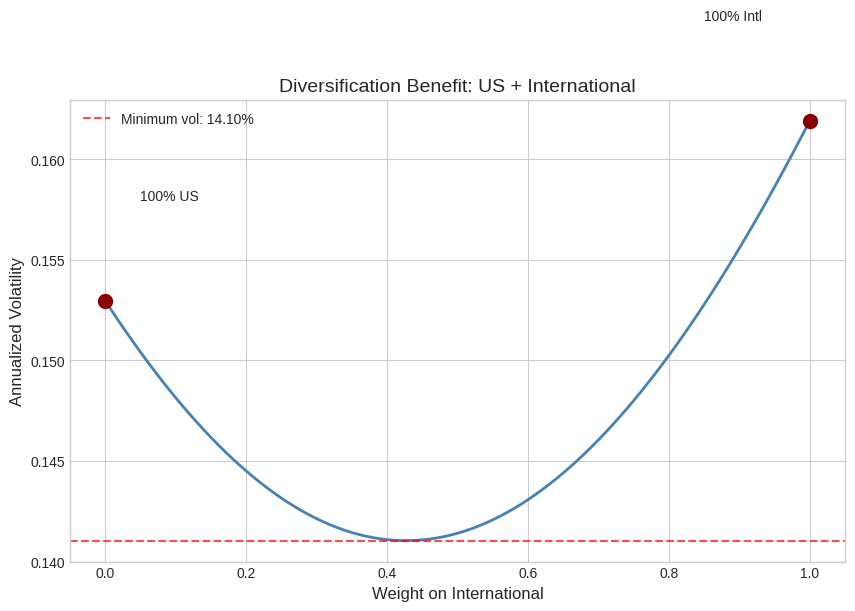

In [16]:
# Plot the diversification benefit
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['Weight_Intl'], results['Volatility'], linewidth=2, color='steelblue')
ax.axhline(y=results['Volatility'].min(), color='red', linestyle='--', alpha=0.7,
           label=f"Minimum vol: {results['Volatility'].min():.2%}")

# Mark pure portfolios
ax.scatter([0, 1], [results.iloc[0]['Volatility'], results.iloc[-1]['Volatility']],
           s=100, zorder=5, color='darkred')
ax.annotate('100% US', (0, results.iloc[0]['Volatility']),
            xytext=(0.05, results.iloc[0]['Volatility'] + 0.005))
ax.annotate('100% Intl', (1, results.iloc[-1]['Volatility']),
            xytext=(0.85, results.iloc[-1]['Volatility'] + 0.005))

ax.set_xlabel('Weight on International', fontsize=12)
ax.set_ylabel('Annualized Volatility', fontsize=12)
ax.set_title('Diversification Benefit: US + International', fontsize=14)
ax.legend()
plt.show()

> **💡 Key Insight:**
>
> Adding a **more volatile** asset can **reduce** portfolio volatility when correlations are below 1!
> This is the power of diversification.

---

## The Mean-Variance Frontier <a id="the-mean-variance-frontier"></a>

Now let's trace the **investment frontier**: how expected returns change with risk.

In [17]:
# Compute mean-variance frontier
E_2 = D.mean() * 12  # Annualized expected returns

frontier = []
for w_intl in np.arange(0, 1.01, 0.01):
    W_2 = np.array([[1 - w_intl], [w_intl]])

    # Expected return
    er = (W_2.T @ E_2)[0]

    # Volatility
    var = (W_2.T @ Cov_2 @ W_2)[0][0]
    vol = np.sqrt(var) * np.sqrt(12)

    frontier.append([w_intl, vol, er])

frontier = pd.DataFrame(frontier, columns=['Weight_Intl', 'Volatility', 'Expected_Return'])

In [18]:
frontier.head()

,Weight_Intl,Volatility,Expected_Return
0,0.00,0.152959,0.062222
1,0.01,0.152427,0.062099
2,0.02,0.151906,0.061976
3,0.03,0.151397,0.061854
4,0.04,0.150898,0.061731


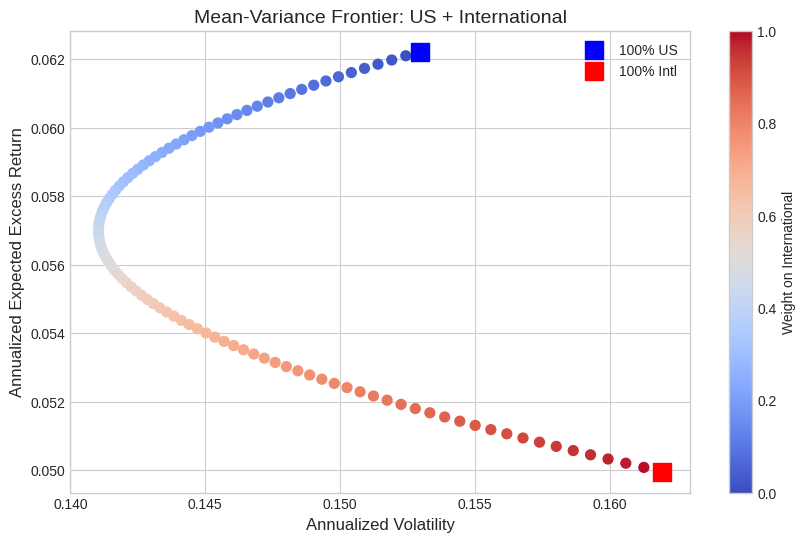

In [19]:
# Plot the mean-variance frontier
fig, ax = plt.subplots(figsize=(10, 6))

# Color by weight on international
scatter = ax.scatter(frontier['Volatility'], frontier['Expected_Return'],
                     c=frontier['Weight_Intl'], cmap='coolwarm', s=50)
plt.colorbar(scatter, label='Weight on International')

# Mark pure portfolios
ax.scatter([frontier.iloc[0]['Volatility']], [frontier.iloc[0]['Expected_Return']],
           s=150, color='blue', marker='s', zorder=5, label='100% US')
ax.scatter([frontier.iloc[-1]['Volatility']], [frontier.iloc[-1]['Expected_Return']],
           s=150, color='red', marker='s', zorder=5, label='100% Intl')

ax.set_xlabel('Annualized Volatility', fontsize=12)
ax.set_ylabel('Annualized Expected Excess Return', fontsize=12)
ax.set_title('Mean-Variance Frontier: US + International', fontsize=14)
ax.legend()
plt.show()

---

## 📝 Exercises <a id="exercises"></a>

### Exercise 1: Warm-up — Custom Portfolio

> **🔧 Exercise:**
>
> Create a portfolio with:
> - 50% in MKT (US equities)
> - 30% in WorldxUSA (International)
> - 20% in Bonds (if available, else EmergingMarkets)
>
> Compute:
> 1. The portfolio's annualized expected excess return
> 2. The portfolio's annualized volatility
> 3. The portfolio's Sharpe ratio

In [20]:
W_ex1 = np.ones((3,))
W_ex1[0] = 0.5
W_ex1[1] = 0.3
W_ex1[2] = 0.2

# W_ex1 = [0.5, 0.3, 0.2]

# print(W_ex1)

D = Data[['MKT', 'WorldxUSA', 'EmergingMarkets']]

eret = D@W_ex1

print(f"annualized excess {eret.mean() * 12}")
print(f"annualized volatility {eret.std() * np.sqrt(12)}")
print(f"annualized sharpe ratio {eret.mean() / (eret.std() * np.sqrt(12))}")

annualized excess 0.06238392712198143
annualized volatility 0.1413550020822973
annualized sharpe ratio 0.03677733732034313


### Exercise 2: Extension — Minimum Variance Portfolio

> **🤔 Think and Code:**
>
> Using only MKT and WorldxUSA:
> 1. Find the weight on international that **minimizes** portfolio volatility
> 2. What is the minimum achievable volatility?
> 3. Compare this to holding 100% US—what's the volatility reduction?

In [24]:
D = Data[['MKT', 'WorldxUSA']]

min_weight = 0
min_vol = 1
for w_intl in np.arange(0, 1.01, 0.01):
    W_2 = np.array([[1 - w_intl], [w_intl]])
    var = (W_2.T @ D.cov() @ W_2)[0][0]

    if var < min_vol:
        min_weight = w_intl
        min_vol = var

print(f"Weight on International: {min_weight}")
print(f"Minimum volatility: {np.sqrt(min_vol) * np.sqrt(12)}")
print(f"US vol: {np.sqrt(D['MKT'].var())}")
print(f"Vol reduction: {(np.sqrt(D['MKT'].var()) - np.sqrt(min_vol))}")


Weight on International: 0.43
Minimum volatility: 0.1410426914741972
US vol: 0.04415534763258244
Vol reduction: 0.0034398296876538906


In [ ]:
# Your code here

### Exercise 3: Open-ended — Three-Asset Frontier

> **🤔 Think and Code:**
>
> Extend the analysis to three assets: MKT, WorldxUSA, and EmergingMarkets.
>
> 1. Create a grid of weights (w_us, w_intl, w_em) that sum to 1
> 2. Compute expected return and volatility for each combination
> 3. Plot the three-asset frontier
> 4. Does adding emerging markets improve the frontier?

In [27]:
# Your code here

D = Data[['MKT', 'WorldxUSA', 'EmergingMarkets']]

E_2 = D.mean() * 12
Cov_2 = D.cov()

frontier = []
for w_intl in np.arange(0, 1.01, 0.01):
    for w_EM in np.arange(0, 1.01 - w_intl, 0.01):
      W_2 = np.array([[1 - w_intl - w_EM], [w_intl], [w_EM]])

      # Expected return
      er = (W_2.T @ E_2)[0]

      # Volatility
      var = (W_2.T @ Cov_2 @ W_2)[0][0]
      vol = np.sqrt(var) * np.sqrt(12)

      frontier.append([w_intl, w_EM, vol, er])

frontier = pd.DataFrame(frontier, columns=['Weight_Intl', 'Weight_EM', 'Volatility', 'Expected_Return'])


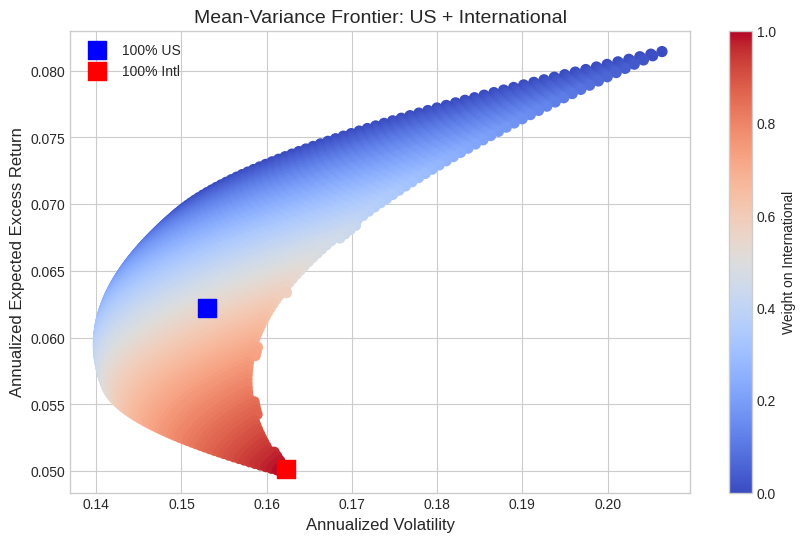

In [28]:
# Plot the mean-variance frontier
fig, ax = plt.subplots(figsize=(10, 6))

# Color by weight on international
scatter = ax.scatter(frontier['Volatility'], frontier['Expected_Return'],
                     c=frontier['Weight_Intl'], cmap='coolwarm', s=50)
plt.colorbar(scatter, label='Weight on International')

# Mark pure portfolios
ax.scatter([frontier.iloc[0]['Volatility']], [frontier.iloc[0]['Expected_Return']],
           s=150, color='blue', marker='s', zorder=5, label='100% US')
ax.scatter([frontier.iloc[-1]['Volatility']], [frontier.iloc[-1]['Expected_Return']],
           s=150, color='red', marker='s', zorder=5, label='100% Intl')

ax.set_xlabel('Annualized Volatility', fontsize=12)
ax.set_ylabel('Annualized Expected Excess Return', fontsize=12)
ax.set_title('Mean-Variance Frontier: US + International', fontsize=14)
ax.legend()
plt.show()

---

## 🧠 Key Takeaways <a id="key-takeaways"></a>

1. **Matrix algebra is your friend** — A single line replaces nested loops when calculating returns, expectations, and variance

2. **Diversification is all about correlations** — Pairing volatile but imperfectly correlated assets can cut overall risk more than simply holding the lower-volatility asset alone

3. **How risky is an asset?** — It fundamentally depends on the portfolio of who is asking

4. **The key formulas:**

| Quantity | Formula |
|----------|--------|
| Portfolio return | $R_p = W'R$ |
| Expected return | $E[R_p] = W'E[R]$ |
| Variance | $\text{Var}(R_p) = W'\Sigma W$ |